In [1]:
# Mounting my drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Navigate to folder where drive is uploaded
import os
os.chdir("/content/drive/MyDrive/UTD/Spring 2023/NLP/Assignments/Text Classification/")

# Print files in the current working directory
print(os.listdir())

['Text-Classification.ipynb', 'fake-news-dataset', 'fake_job_postings.csv', 'Presentation Notes.gdoc']


Rows and columns: (17880, 18)
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                

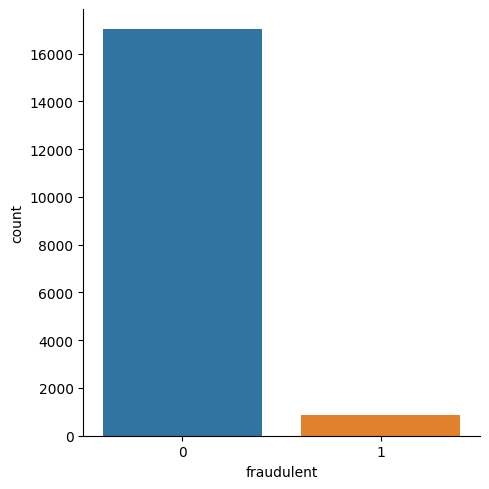

In [3]:
import pandas as pd
import seaborn as sb

# read the csv file and put in a dataframe
df = pd.read_csv("fake_job_postings.csv")

# plot the distribution of classes
sb.catplot(x="fraudulent", kind="count", data=df)

print("Rows and columns:", df.shape)
print(df.head())

word cloud for real job postings


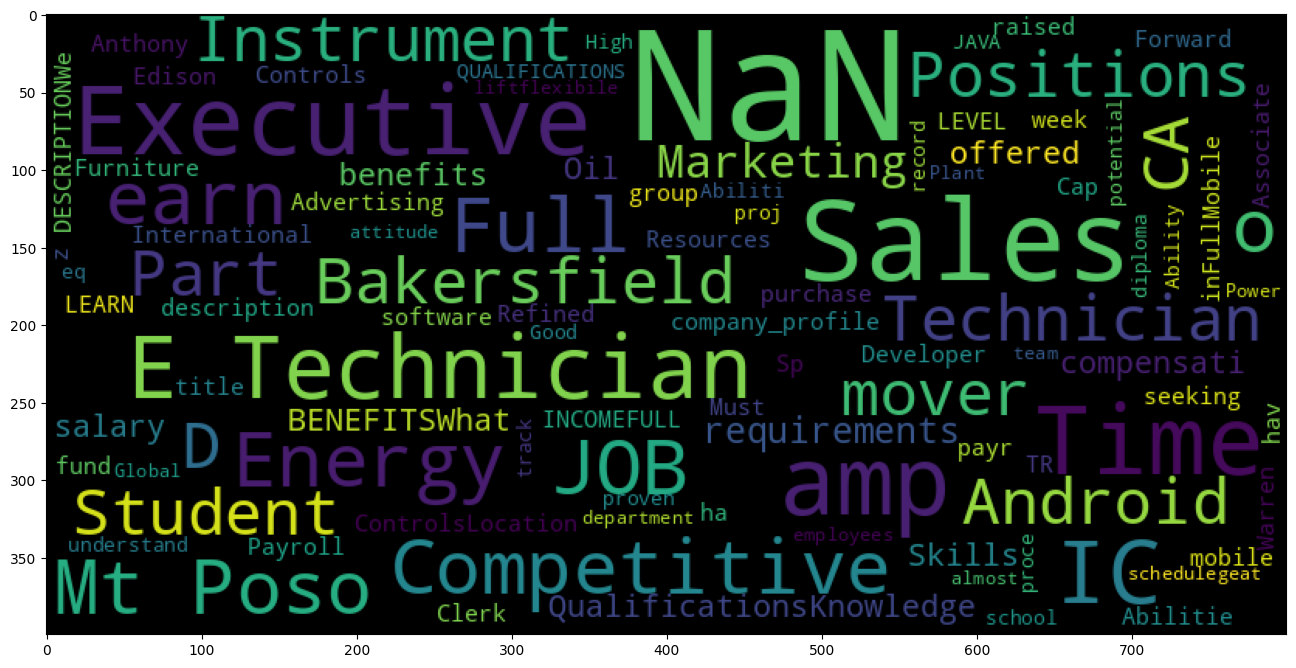

In [4]:
# make a wordcloud
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt 

wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 100, max_font_size = 100, 
                random_state = 42, width=800, height=400)

plt.figure(figsize=(16, 12))

print("word cloud for real job postings")
wordcloud.generate(str(df.loc[df['fraudulent'] == 1, ["description", "title", "company_profile", "requirements", "benefits", "department"]]))
plt.imshow(wordcloud)



## Analysis on Wordcloud

It's interesting that the term `student` is common in fraudulent job descriptions, I suspect because this type of postings target students who are desperate for jobs. I also suspect that the mere presence of the word `student` will be a good indicator of whether the job posting is fake or real.

Based on similar reasoning, I suspect words such as `executive` and `NaN` may also be strong indicators of a fake job posting

## Filling null descriptions with an empty string

In [5]:
print(df.isnull().sum())
print()

# fill null values with an empty string
df.fillna('', inplace=True)
print(df.isnull().sum())


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


# The Dataset 
The dataset contains job postings with the following text features:
`"title", "description", "location", "department", "company_profile", "requirements", "benefits"`

The dataset also contains a "fraudulent" column, which indicates whether that observations is a real or fake job posting

# What the Model Should Predict
The model should be able to take in a job posting and predict whether or not it is real. This could be really useful for job sites to protect their users from being scammed by fake job postings

# Setting up X and y

In [6]:
# Define the list of text columns to use
text_columns = ["title", "description", "location", "department", "company_profile", "requirements", "benefits"]

# Combine all the text columns into a single column
df['combined_text'] = df[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Set up X(predictors) and y(target)
X = df.combined_text
y = df.fraudulent

# take a peek at X
print(X.head(), "\n")

# take a peek at y
print(y.head())

0    Marketing Intern Food52, a fast-growing, James...
1    Customer Service - Cloud Video Production Orga...
2    Commissioning Machinery Assistant (CMA) Our cl...
3    Account Executive - Washington DC THE COMPANY:...
4    Bill Review Manager JOB TITLE: Itemization Rev...
Name: combined_text, dtype: object 

0    0
1    0
2    0
3    0
4    0
Name: fraudulent, dtype: int64


# Using Naive Bayes 

### First Attempt

Uses the MultinomialNB classifer, which takes in multinomially distributed data, meaning that each feature represents the tf-idf of an ngram

#### Train and Test Split
Split the data into train and test sets, with 20% going to the test set

In [7]:
# train and test set split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=1234)

X_train.shape

(14304,)

#### Text Preprocessing

In [8]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


stopwords = list(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2), max_features=50000, min_df=2)

# apply tfidf vectorizer
X_train = vectorizer.fit_transform(X_train) # learn vocabulary and get document-term matrix for each document
X_test = vectorizer.transform(X_test) # get the document-term matrix for each test document

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Train the Naive Bayes Classifier

In [9]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

#### Evaluate on test data

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# make predictions on the test data
pred = naive_bayes.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))

[[3390    1]
 [ 126   59]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3391
           1       0.98      0.32      0.48       185

    accuracy                           0.96      3576
   macro avg       0.97      0.66      0.73      3576
weighted avg       0.97      0.96      0.96      3576



#### Taking a closer look at the wrong predictions

In [11]:
y_test[y_test != pred]

17687    1
4807     1
4743     1
17711    1
17559    1
        ..
997      1
11507    1
3274     1
8247     1
4675     1
Name: fraudulent, Length: 127, dtype: int64

In [12]:
for i in [17687, 4807, 4743, 17559, 17720, 11541, 997, 11507, 8247, 4675]:
  print(df.loc[i]["description"])

We are seeking extremely motivated and experienced individual for position of  Data Entry clerk/Administartive Asistance/Customer Service/Receiptionist/Pay roll office ..Position: Full time and part-time (30-40 hours per week Monday through Friday daytime) The position is for full-time and part-time positions available within the company.. Benefits include health, dental, vacation time, sick leave, and 401K
Arise Virtual Solutions is a work-at-home business process outsourcing company we have an immediate opening for a mid-level administrative assistant for our corporate office in Miramar, FL. The successful candidate must be an aggressive self-starter that possesses strong organizational and communication skills while working under strict timelines.Hilscher-Clarke Electric Company is an equal opportunity employer.Primary Responsibilities:- Provide administrative support to Project Managers, Estimators and Technicians/Electricians- Accurately maintain and organize project submittals an

### Second Attempt

Uses the BernoulliNB classifier. The difference from the first attempt is that the model will train on whether a word is present or not, rather than its tf-idf

#### Train and Test Split
Split the data into train and test sets, with 20% going to the test set

In [13]:
# train and test set split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

X_train.shape

(14304,)

#### Text Preprocessing

In [14]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


stopwords = list(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2), max_features=50000, min_df=2, binary=True)

# apply tfidf vectorizer
X_train = vectorizer.fit_transform(X_train) # learn vocabulary and get document-term matrix for each document
X_test = vectorizer.transform(X_test) # get the document-term matrix for each test document

#### Train the Naive Bayes Classifier

In [15]:
from sklearn.naive_bayes import BernoulliNB

naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train)

BernoulliNB()

#### Evaluate on test data

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# make predictions on the test data
pred = naive_bayes.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))

[[3241  154]
 [  22  159]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3395
           1       0.51      0.88      0.64       181

    accuracy                           0.95      3576
   macro avg       0.75      0.92      0.81      3576
weighted avg       0.97      0.95      0.96      3576



### Third Attempt: Dealing with the inbalanced classes

Uses a ComplmentNB, which is mean to be suited for inbalanced datasets. Also adjust the `sample_weights` parameter to make up for the class imbalance

#### Train and Test Split
Split the data into train and test sets, with 20% going to the test set

In [17]:
# train and test set split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

X_train.shape

(14304,)

#### Text Preprocessing

In [18]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


stopwords = list(stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2), max_features=50000, min_df=2, binary=True)

# apply tfidf vectorizer
X_train = vectorizer.fit_transform(X_train) # learn vocabulary and get document-term matrix for each document
X_test = vectorizer.transform(X_test) # get the document-term matrix for each test document

#### Train the Naive Bayes Classifier

In [19]:
from sklearn.naive_bayes import ComplementNB
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

naive_bayes = ComplementNB()

# calculate the class weights based on the frequency of the samples
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(class_weights)

# create a dictionary that maps each class to its corresponding weight
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# create an array of sample weights based on the class of each sample
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# fit the classifier to the training data with the calculated class weights
naive_bayes.fit(X_train, y_train, sample_weight=sample_weights)

[ 0.52514869 10.44087591]


ComplementNB()

#### Evaluate on test data

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# make predictions on the test data
pred = naive_bayes.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))

[[3179  216]
 [  13  168]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3395
           1       0.44      0.93      0.59       181

    accuracy                           0.94      3576
   macro avg       0.72      0.93      0.78      3576
weighted avg       0.97      0.94      0.95      3576



## Analysis on the Naive Bayes Classifiers

The Binomial classifier performed better than the Multinomial classifier. This suggests that the presence or absence of a given word carries greater significance as a distinguishing feature for class assignment, as compared to its tf-idf weight.

In the third attempt, I used the the `ComplementNB` classifier, which is meant for datasets with imbalanced classes. I also adjusted the class weights to give more weight to the smaller class. This improved the recall for the underepresented class at the cost of a reduced precision for that class (which makes sense, we correctly identify many more True observations at the cost of also incorrectly identifying a few more False observations as True).

# Using Logistic Regression

## First Attempt

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(binary=True)),
    ('logreg', LogisticRegression(solver='lbfgs', class_weight="balanced"))
])

# Training the model
pipeline.fit(X_train, y_train)

# Evaluating the model
pred = pipeline.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))


[[3359   36]
 [  18  163]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.82      0.90      0.86       181

    accuracy                           0.98      3576
   macro avg       0.91      0.94      0.92      3576
weighted avg       0.99      0.98      0.99      3576



## Second Attempt: Oversampling under-represented class

[[3370   25]
 [  25  156]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.86      0.86      0.86       181

    accuracy                           0.99      3576
   macro avg       0.93      0.93      0.93      3576
weighted avg       0.99      0.99      0.99      3576



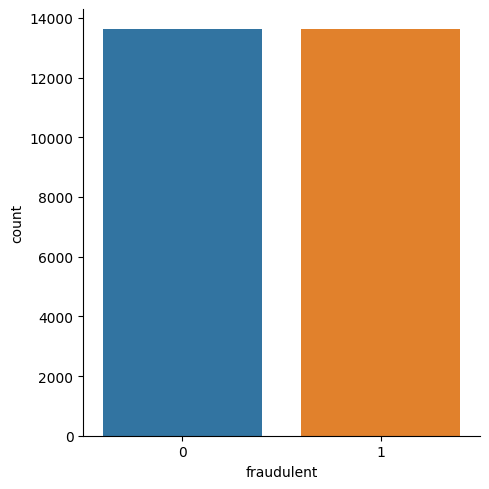

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import seaborn as sb

# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(binary=True)),
    ('logreg', LogisticRegression(solver='lbfgs', class_weight="balanced"))
])

# Define oversampler
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the oversampling to the training set
X_train = X_train.to_numpy().reshape(-1, 1)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

X_train_resampled = X_train_resampled.flatten()
X_train_resampled = pd.Series(X_train_resampled)

# plot new class distributions
resampled_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)
sb.catplot(x="fraudulent", kind="count", data=resampled_df)

# Training the model
pipeline.fit(X_train_resampled, y_train_resampled)

# Evaluating the model
pred = pipeline.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))


In [23]:
pipeline.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(binary=True)),
  ('logreg', LogisticRegression(class_weight='balanced'))],
 'verbose': False,
 'tfidf': TfidfVectorizer(binary=True),
 'logreg': LogisticRegression(class_weight='balanced'),
 'tfidf__analyzer': 'word',
 'tfidf__binary': True,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': 'balanced',
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg

## Third Attempt
Increasing C values of logistic regression, which reduces the strengh of regularization, allowing the the model to fit the data more closely (mitigates underfitting). 

Increasing min_df to ignore very infrequent terms

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(binary=True)),
    ('logreg', LogisticRegression(solver='lbfgs', class_weight="balanced"))
])

# Define oversampler
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the oversampling to the training set
X_train = X_train.to_numpy().reshape(-1, 1)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

X_train_resampled = X_train_resampled.flatten()
X_train_resampled = pd.Series(X_train_resampled)

# Training the model
pipeline.set_params(tfidf__min_df=3, logreg__C=3.0).fit(X_train_resampled, y_train_resampled)

# Evaluating the model
pred = pipeline.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))


[[3381   14]
 [  29  152]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.92      0.84      0.88       181

    accuracy                           0.99      3576
   macro avg       0.95      0.92      0.93      3576
weighted avg       0.99      0.99      0.99      3576



## Fourth Attempt: 

Using GridSearchCV to find optimal values for the hyper parameters.

In [25]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search over
param_grid = {
    'tfidf__min_df': [2, 3, 4],
    'logreg__C': [0.1, 1.0, 10.0],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Get the best model and use it to make predictions on the test set
best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)

# Print the confusion matrix and classification report for the best model
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Best parameters found:  {'logreg__C': 10.0, 'tfidf__min_df': 2}
[[3387    8]
 [  35  146]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.95      0.81      0.87       181

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576



## Analysis on the Logistic Regression Classifiers

Right away we notice we get much better results accross the board with Logistic Regression as opposed to all of the Naive Bayes classifiers.

In the second attempt, I tried oversampling the under-represnted class (fraudulent). This resulted in a slightly improved precision at the cost of a slightly worse recall. The f1-score stayed the same

In the third and fourth attempt, I tried using the hyperparameters to get better results. Manually tuning them helped improve precision, but using GridSearchCV found a better tuning.

# Using Neural Networks

## First Attempt

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from nltk.corpus import stopwords

import nltk

# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

stopwords = list(stopwords.words('english'))

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, binary=True)),
    ('nn',  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2), random_state=42))
])

# Training the model
pipeline.fit(X_train, y_train)

# Evaluating the model
pred = pipeline.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred, zero_division=0))

[[3395    0]
 [ 181    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3395
           1       0.00      0.00      0.00       181

    accuracy                           0.95      3576
   macro avg       0.47      0.50      0.49      3576
weighted avg       0.90      0.95      0.92      3576



## Attempt 2
Oversampling to mitigate class imbalance

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from nltk.corpus import stopwords

# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

stopwords = list(stopwords.words('english'))

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, binary=True)),
    ('nn',  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2), random_state=42))
])

# Define oversampler
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the oversampling to the training set
X_train = X_train.to_numpy().reshape(-1, 1)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

X_train_resampled = X_train_resampled.flatten()
X_train_resampled = pd.Series(X_train_resampled)

# Training the model
pipeline.fit(X_train_resampled, y_train_resampled)

# Evaluating the model
pred = pipeline.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred, zero_division=0))

[[3395    0]
 [ 181    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3395
           1       0.00      0.00      0.00       181

    accuracy                           0.95      3576
   macro avg       0.47      0.50      0.49      3576
weighted avg       0.90      0.95      0.92      3576



## Attempt 3
extra nodes in hidden layer to mitigate underfitting

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from nltk.corpus import stopwords

# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

stopwords = list(stopwords.words('english'))

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, binary=True)),
    ('nn',  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 8), random_state=42))
])

# Training the model
pipeline.fit(X_train, y_train)

# Evaluating the model
pred = pipeline.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))

[[3388    7]
 [  37  144]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.95      0.80      0.87       181

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576



## Attempt 4

- even more extra nodes in hidden layer to mitigate underfitting (93468 predictors, so we should have a lot of nodes)
- Using solver 'adam'. Works well on large datasets and has been shown to perform better than other solvers in terms of accuracy


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from nltk.corpus import stopwords

# train and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

stopwords = list(stopwords.words('english'))

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, binary=True)),
    ('nn',  MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(64, 32, 16, 8), random_state=42))
])

# Training the model
pipeline.fit(X_train, y_train)

# printing the number of predictors
input_layer_size = len(pipeline.named_steps['tfidf'].vocabulary_)
print("Number of predictors after vectorization:", input_layer_size)

# Evaluating the model
pred = pipeline.predict(X_test)

# print confusion matrix
print(confusion_matrix(y_test, pred))

# print the classification report
print(classification_report(y_test, pred))

Number of predictors after vectorization: 93468
[[3392    3]
 [  47  134]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.98      0.74      0.84       181

    accuracy                           0.99      3576
   macro avg       0.98      0.87      0.92      3576
weighted avg       0.99      0.99      0.99      3576



# Analysis on the Neural Networks

Attempts 1 and 2 did not identify any of the fraudulent observations. In attempt 2, I oversampling to help with the class imbalance, but the model still could not identify any fraudulent observations. Therefore I concluded that the issue was that my model was underfitting due to having too few nodes in my neural network.

In Attempt 3, I incresed the amount of nodes in my hidden layers and this dramatically improved the model. Comparing this attempt with Attempt 4 on the Logistic regression, we can see that they have very similar performance, except that the Neural Network has slightly better Recall for the fraudulent class at the tradeoff of slightly worse accuracy. 

In attempt 4, I put a lot more nodes on the neural network and used the 'adam' solver instead. This dramatically improved precision at the cost of a recall.

I belive that, for a job site, it might be better to use the Fourth Neural Network. This is because the tradeoff of improved precision for reduced recall makes sense for this particular use case. I believe that a job site would prefer avoiding false flagging real job applications as fraudulent, as this could annoy their users quite a bit, therefore precision would be more important to them than recall.